# AB Test Data Analysis
- 출처 : https://www.kaggle.com/code/sergylog/ab-test-data-analysis

## 1. Loading and processing data 

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [21]:
df = pd.read_csv('AB_Test_Results.csv')

- 데이터 탐색

In [22]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [23]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [24]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


- a/b test 그룹 확인

In [25]:
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [26]:
double_variant_count / double_variant_count.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

> 👉 2개 처치가 모두 적용된 유저가 섞이면, 결과 해석이 어려워진다. 따라서, 이러한 유저들은 제외하고 분석한다

In [27]:
# 1개의 테스트 그룹에 속한 유저만 보기
single_variant_users = df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1
single_variant_users

USER_ID
2         True
3        False
4         True
5         True
6         True
         ...  
9993      True
9995      True
9996     False
9998      True
10000    False
Name: VARIANT_NAME, Length: 6324, dtype: bool

In [28]:
# 1개 그룹에만 속한 유저 필터링
df = df[df['USER_ID'].isin(single_variant_users.index)]

In [29]:
# 행 개수 확인
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

- 데이터 분포 확인

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

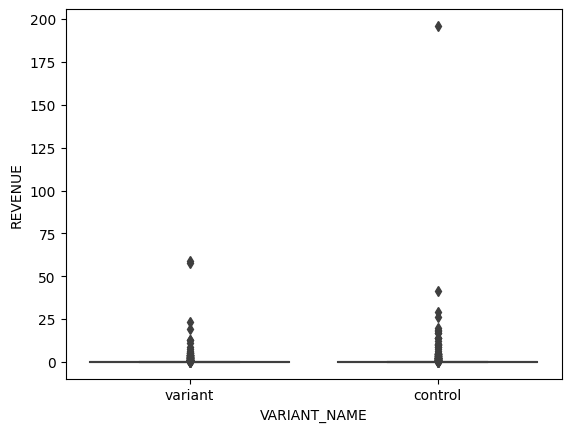

In [30]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

> outlier 확인 : 추후 매출액 내림차순으로 확인

In [34]:
# 이상치 찾기
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32
9125,831,control,25.98
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56


In [35]:
df[df['USER_ID']==3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


- userid 3342인 건이 여러건으로 잡혀서 수익이 커졌는지 확인 필요 ->> 단일 건으로, 삭제 결정

In [36]:
# 해당 이상치 제외
df = df[df['USER_ID']!=3342]

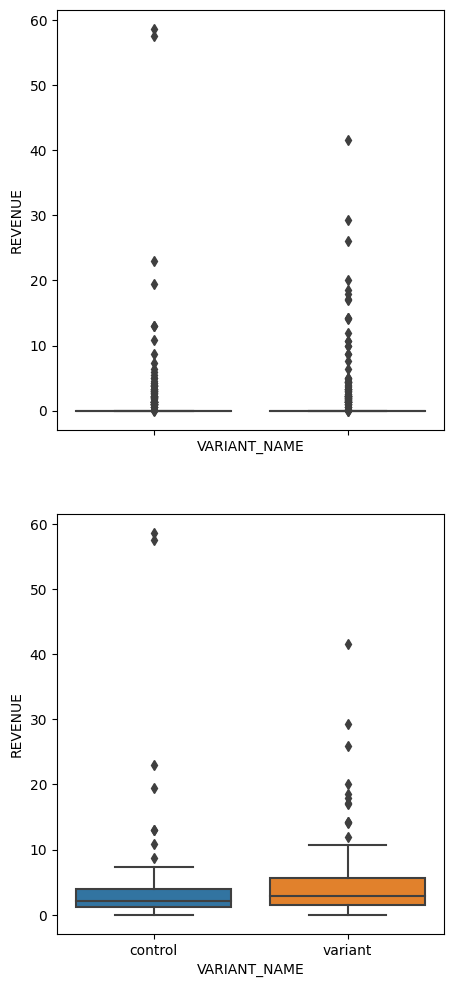

In [38]:
f, axes = plt.subplots(2, sharex=True, figsize = (5, 12))
sns.boxplot(ax=axes[0], x='VARIANT_NAME', y='REVENUE', data=df)
sns.boxplot(ax=axes[1], x='VARIANT_NAME', y='REVENUE', data=df[df['REVENUE']>0])
plt.xticks(np.arange(2), ('control', 'variant'))
plt.show()

- 대부분의 고객의 구매가 없음을 확인  

In [39]:
# 구매가 없는/있는 고객 비교
(df.loc[(df['REVENUE']==0)&(df['USER_ID'].isin(df.loc[df['REVENUE']>0, 'USER_ID'].values)), 'USER_ID']).count()

156

- 구매가 0으로 잡혔지만, 사실 0보다 큰 구매 건도 있는 사실 확인 >> 고객별 데이터가 중복됨

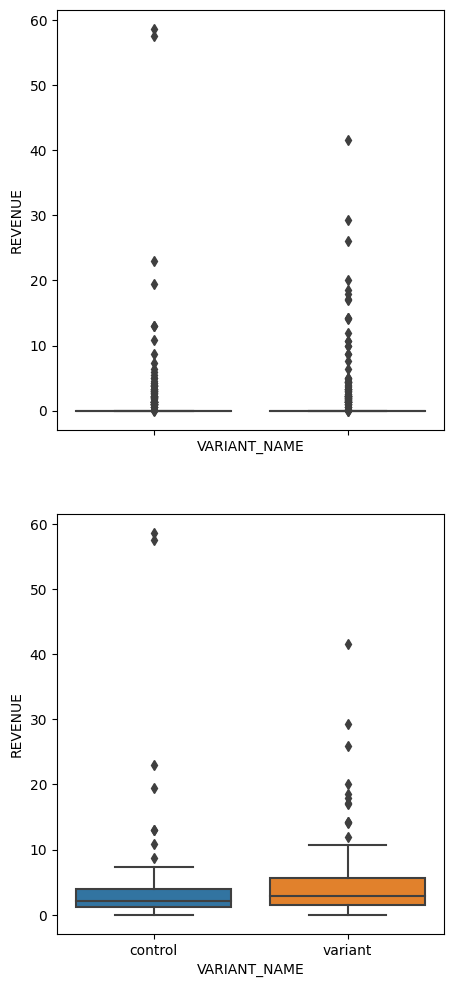

In [40]:
f, axes = plt.subplots(2, sharex=True, figsize = (5, 12))
sns.boxplot(ax=axes[0], x='VARIANT_NAME', y='REVENUE', data=df)
sns.boxplot(ax=axes[1], x='VARIANT_NAME', y='REVENUE', data=df[df['REVENUE']>0])
plt.xticks(np.arange(2), ('control', 'variant'))
plt.show()

- 그룹별로 묶어서 확인해보기

In [42]:
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID':'nunique',
                                             'REVENUE':['sum', 'mean', 'median', 'count']})

In [43]:
all_stat

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control         3930  446.99  0.089703    0.0  4983
variant         3934  351.47  0.070070    0.0  5016

- 각 사용자별로 주문이 얼마나 자주 발생하는지를 평가하기 위한 지표(사용자 1명당 평균 구매 횟수를 계산)
-  'REVENUE' 열의 합계를 모든 통계에서 'USER_ID' 열의 고유 사용자 수로 나눈 값

In [47]:
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
orders_per_user

VARIANT_NAME
control    1.267939
variant    1.275038
dtype: float64

- 평균 사용자당 총 매출(사용자당 평균적으로 발생한 총 매출을 계산하는 데 사용되는 지표)

In [49]:
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user

VARIANT_NAME
control    0.113738
variant    0.089342
dtype: float64

In [53]:
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

In [54]:
all_stat

USER_ID REVENUE                         per_user          
             nunique     sum      mean median count    orders   revenue
VARIANT_NAME                                                           
control         3930  446.99  0.089703    0.0  4983  1.267939  0.113738
variant         3934  351.47  0.070070    0.0  5016  1.275038  0.089342

> test 그룹에서 유저 1명당 수익이 줄어듦 확인, 하지만 구매 횟수는 늘어났음

- 구매한 유저들의 행동 체크

In [60]:
paid_stat = df.loc[df.REVENUE != 0].groupby('VARIANT_NAME').agg({'USER_ID':'nunique',
                                                                'REVENUE':['sum', 'mean', 'median', 'count']})

In [61]:
paid_stat

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control           79  446.99  5.658101   2.93    79
variant           71  351.47  4.881528   2.17    72

In [65]:
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]

In [66]:
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

- 모든 유저의 수익 분포 & 구매를 한 유저의 수익 분포 비교

/var/folders/hj/1c4sv0bn28v5lr5g0s_fr4w80000gn/T/ipykernel_31529/786425308.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME']=='control', 'REVENUE'], ax=axes[0], label='control')
/var/folders/hj/1c4sv0bn28v5lr5g0s_fr4w80000gn/T/ipykernel_31529/786425308.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

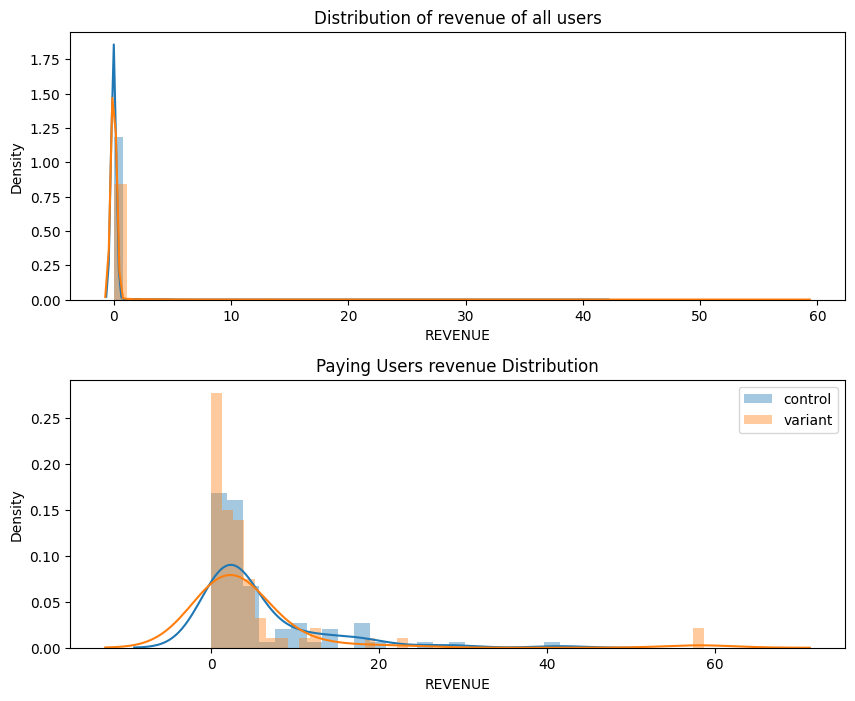

In [73]:
f, axes = plt.subplots(2, figsize = (10, 8))
sns.distplot(df.loc[df['VARIANT_NAME']=='control', 'REVENUE'], ax=axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME']=='variant', 'REVENUE'], ax=axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

sns.distplot(df.loc[(df.VARIANT_NAME == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax=axes[1], label='control')
sns.distplot(df.loc[(df.VARIANT_NAME == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax=axes[1], label='variant')
axes[1].set_title('Paying Users revenue Distribution')
plt.legend()
plt.subplots_adjust(hspace=0.3) 

- 구매한 고객에 대해서만 비교한 결과, 실험집단의 수익 분포가 뚜렷하게 높은 구간이 확인됨

### 통계 분석
#### 1. 정규분포 여부 : shapiro-Wilk 검정

In [75]:
shapiro(df.loc[df.VARIANT_NAME=='variant', 'REVENUE'])

/Users/angela/opt/anaconda3/envs/mulcamp/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.027033090591430664, pvalue=0.0)

- 실험집단의 수익 분포가 정규분포가 아님을 확인

#### 2. Mann-Whitney 검정
- 수익이 0인 값과 중복값이 많은 데이터이므로 유의해야함
- 만-위트니 검정(Mann-Whitney U 검정)은 두 개의 독립적인 표본 간의 비모수적인 비교를 수행하기 위해 사용된다. 비모수 검정은 데이터가 정규 분포를 따르지 않거나 모집단에 대한 분포에 대한 가정을 만족하지 않을 때 사용한다.

In [76]:
(df['REVENUE']==0).value_counts()

True     9848
False     151
Name: REVENUE, dtype: int64

In [77]:
mannwhitneyu(df.loc[df.VARIANT_NAME=='variant', 'REVENUE'], df.loc[df.VARIANT_NAME=='control', 'REVENUE'])

MannwhitneyuResult(statistic=12478180.0, pvalue=0.5291970335120277)

- 실험집단과 통제집단의 수익에 대한 비모수 검정 결과
- statistics : 두 집단 간 순위합으로, 집단이 유사하면 값이 작고, 집단 차이가 크면 큰 값이 나옴
- pvalue : 통계적으로 유의미한 차이가 없음
- 즉, 두 집단간 차이가 통계적으로 유의미하지 않음

#### 2-2. 수익이 발생한 경우에 대해서만 수행
- 역시 유의미한 차이없음

In [78]:
mannwhitneyu(df.loc[(df.VARIANT_NAME=='control')&(df.REVENUE>0), 'REVENUE'],
            df.loc[(df.VARIANT_NAME=='variant')&(df.REVENUE>0), 'REVENUE'])

MannwhitneyuResult(statistic=3284.0, pvalue=0.10145877111519161)

#### Bootstrap
- AB 테스트 그룹 간 평균 값의 차이에 대한 완전한 정보를 얻기 위해 부트스트래핑을 사용하는 함수를 만들기
- 부트스트래핑은 통계치를 추정하는 강력한 리샘플링 기술

In [83]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data))) #무작위 인덱스 배열
    samples = data[indices]
    return samples

In [90]:
# 부트스트랩 샘플로 계산한 통계량의 신뢰구간(신뢰수준 95%)
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha/2., 100 * (1 - alpha/2.)])
    return boundaries

In [92]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME=='control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME=='variant', 'REVENUE'].values, 10000)

In [93]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

/var/folders/hj/1c4sv0bn28v5lr5g0s_fr4w80000gn/T/ipykernel_31529/3053839294.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
/var/folders/hj/1c4sv0bn28v5lr5g0s_fr4w80000gn/T/ipykernel_31529/3053839294.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')


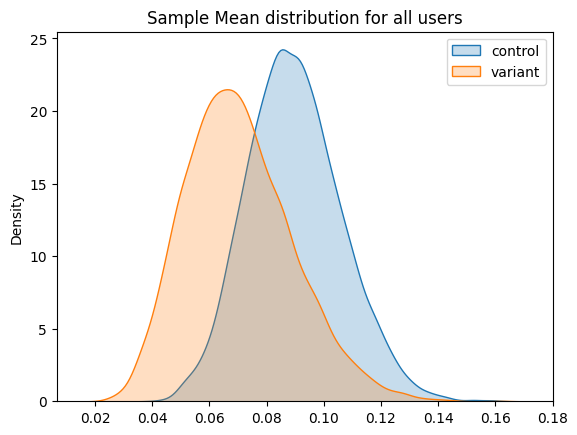

In [96]:
f, ax = plt.subplots()
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample Mean distribution for all users')
plt.legend()
plt.show()

/var/folders/hj/1c4sv0bn28v5lr5g0s_fr4w80000gn/T/ipykernel_31529/3708957539.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
/var/folders/hj/1c4sv0bn28v5lr5g0s_fr4w80000gn/T/ipykernel_31529/3708957539.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')


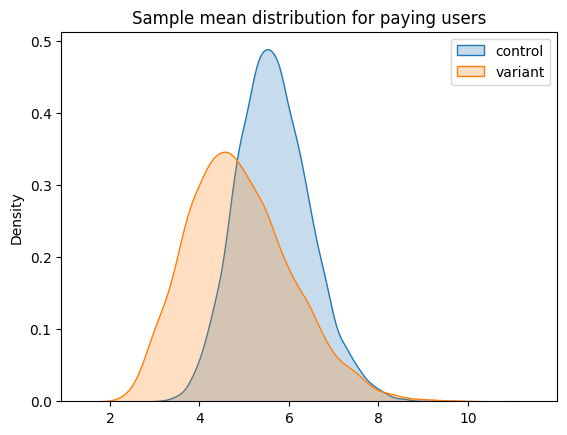

In [98]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')
plt.legend()
plt.show()